In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
import os

# Check file size and type
file1 = '../data/spacenet/ims.np'
file2 = '../data/spacenet/mas.np'

print("🔍 CHECKING FILES:")
print(f"ims.np size: {os.path.getsize(file1)} bytes")
print(f"mas.np size: {os.path.getsize(file2)} bytes")

# Try to read as raw binary
with open(file1, 'rb') as f:
    first_bytes = f.read(100)  # Read first 100 bytes
    print(f"\nFirst 100 bytes of ims.np: {first_bytes}")

with open(file2, 'rb') as f:
    first_bytes = f.read(100)
    print(f"First 100 bytes of mas.np: {first_bytes}")

🔍 CHECKING FILES:
ims.np size: 5284823265 bytes
mas.np size: 1321205982 bytes

First 100 bytes of ims.np: b'\x80\x03cjoblib.numpy_pickle\nNumpyArrayWrapper\nq\x00)\x81q\x01}q\x02(X\x08\x00\x00\x00subclassq\x03cnumpy\nndarray\nq\x04X\x05\x00\x00\x00shapeq\x05(M\xec\x04M'
First 100 bytes of mas.np: b'\x80\x03cjoblib.numpy_pickle\nNumpyArrayWrapper\nq\x00)\x81q\x01}q\x02(X\x08\x00\x00\x00subclassq\x03cnumpy\nndarray\nq\x04X\x05\x00\x00\x00shapeq\x05M\xec\x04M\x00'


In [7]:
import joblib
import numpy as np

# Load the data
images = joblib.load('../data/spacenet/ims.np')
masks = joblib.load('../data/spacenet/mas.np')

print("🛰️ SPACENET DATA LOADED:")
print(f"Images: {images.shape}, dtype: {images.dtype}, range: [{images.min()}, {images.max()}]")
print(f"Masks: {masks.shape}, dtype: {masks.dtype}, unique values: {np.unique(masks)}")

🛰️ SPACENET DATA LOADED:
Images: (1260, 1024, 1024, 4), dtype: uint8, range: [0, 255]
Masks: (1260, 1024, 1024), dtype: uint8, unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 21

In [8]:


print("🔍 COMPREHENSIVE DATA QUALITY CHECK:")

# 1. Check for missing values
print(f"1. Missing pixels in images: {np.isnan(images).sum()}")
print(f"2. Missing pixels in masks: {np.isnan(masks).sum()}")

# 2. Check for duplicate images (this might take a moment)
print("3. Checking for duplicate images...")
# For large datasets, check sample of first 100 images
sample_images = images[:100]
unique_count = len(np.unique(sample_images, axis=0))
print(f"   Unique images in sample: {unique_count}/100")

# 3. Check for invalid images
print("4. Checking for invalid images...")
black_images = np.all(images == 0, axis=(1,2,3)).sum()
white_images = np.all(images == 255, axis=(1,2,3)).sum()
print(f"   Completely black images: {black_images}")
print(f"   Completely white images: {white_images}")

# 4. Check image-mask alignment
print("5. Checking image-mask alignment...")
print(f"   Same number of images/masks: {len(images) == len(masks)}")

# 5. Check mask validity
print("6. Checking mask validity...")
invalid_masks = (masks < 0).sum() + (masks > 255).sum()
print(f"   Invalid mask values: {invalid_masks}")

print("\n✅ DATA QUALITY CHECK COMPLETED!")

🔍 COMPREHENSIVE DATA QUALITY CHECK:
1. Missing pixels in images: 0
2. Missing pixels in masks: 0
3. Checking for duplicate images...
   Unique images in sample: 100/100
4. Checking for invalid images...
   Completely black images: 15
   Completely white images: 0
5. Checking image-mask alignment...
   Same number of images/masks: True
6. Checking mask validity...
   Invalid mask values: 0

✅ DATA QUALITY CHECK COMPLETED!


In [9]:
print("🛠️ HANDLING INVALID BLACK IMAGES...")

# Remove the 15 completely black images
valid_indices = []
for i in range(len(images)):
    if not np.all(images[i] == 0):  # Keep only non-black images
        valid_indices.append(i)

# Filter out black images
images_clean = images[valid_indices]
masks_clean = masks[valid_indices]

print(f"Removed {len(images) - len(images_clean)} black images")
print(f"Clean dataset: {len(images_clean)} images")
print(f"Masks cleaned: {len(masks_clean)} masks")

# Verify the fix
black_images_after = np.all(images_clean == 0, axis=(1,2,3)).sum()
print(f"Black images after cleaning: {black_images_after}")

🛠️ HANDLING INVALID BLACK IMAGES...
Removed 15 black images
Clean dataset: 1245 images
Masks cleaned: 1245 masks
Black images after cleaning: 0


In [11]:
import cv2 

In [12]:
print("🖼️ RESIZING IMAGES TO 256x256...")

# ✅ ADD THIS MISSING FUNCTION DEFINITION:
def resize_batch(images, masks, new_size=(256, 256)):
    """Resize images and masks in batches to save memory"""
    X_resized = []
    y_resized = []
    
    for i in range(len(images)):
        # Resize image (use area interpolation for downsampling)
        img_resized = cv2.resize(images[i], new_size, interpolation=cv2.INTER_AREA)
        # Resize mask (use nearest neighbor to preserve binary labels)
        mask_resized = cv2.resize(masks[i], new_size, interpolation=cv2.INTER_NEAREST)
        
        X_resized.append(img_resized)
        y_resized.append(mask_resized)
    
    return np.array(X_resized), np.array(y_resized)

# ✅ NOW this will work:
X_resized, y_resized = resize_batch(images_clean, masks_clean, new_size=(256, 256))

print(f"✅ RESIZING COMPLETE:")
print(f"Before: {images_clean.shape}")
print(f"After:  {X_resized.shape}")

# Normalize to 0-1 range
X_normalized = X_resized.astype('float32') / 255.0
y_binary = (y_resized > 0).astype('float32')

print(f"✅ NORMALIZATION COMPLETE:")
print(f"Images range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"Masks unique values: {np.unique(y_binary)}")

🖼️ RESIZING IMAGES TO 256x256...
✅ RESIZING COMPLETE:
Before: (1245, 1024, 1024, 4)
After:  (1245, 256, 256, 4)
✅ NORMALIZATION COMPLETE:
Images range: [0.000, 1.000]
Masks unique values: [0. 1.]


In [13]:


print("💾 SAVING PREPROCESSED SPACENET DATA...")

# First, let's do train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_binary, 
    test_size=0.2, random_state=42, shuffle=True
)

print(f"✅ TRAIN-VALIDATION SPLIT:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")

# Save the preprocessed data
np.save('../data/spacenet/X_train.npy', X_train)
np.save('../data/spacenet/X_val.npy', X_val)
np.save('../data/spacenet/y_train.npy', y_train)
np.save('../data/spacenet/y_val.npy', y_val)

print("🎉 SPACENET DATA SAVED! 🎉")
print(f"✅ Total images: {X_train.shape[0] + X_val.shape[0]}")
print(f"✅ Image size: {X_train.shape[1:]}")

💾 SAVING PREPROCESSED SPACENET DATA...
✅ TRAIN-VALIDATION SPLIT:
Training: (996, 256, 256, 4), (996, 256, 256)
Validation: (249, 256, 256, 4), (249, 256, 256)
🎉 SPACENET DATA SAVED! 🎉
✅ Total images: 1245
✅ Image size: (256, 256, 4)


=== DATA CHECK ===
X_train shape: (996, 256, 256, 4)
X_train dtype: float32
X_train range: [0.000, 1.000]
y_train shape: (996, 256, 256)
y_train dtype: float32
y_train range: [0.000, 1.000]

=== Testing single image ===


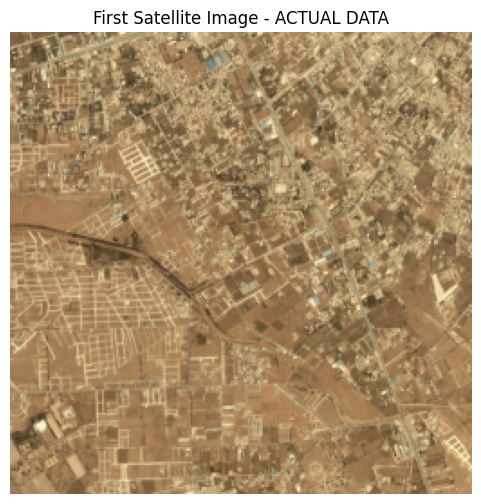


=== Displaying all images and masks ===


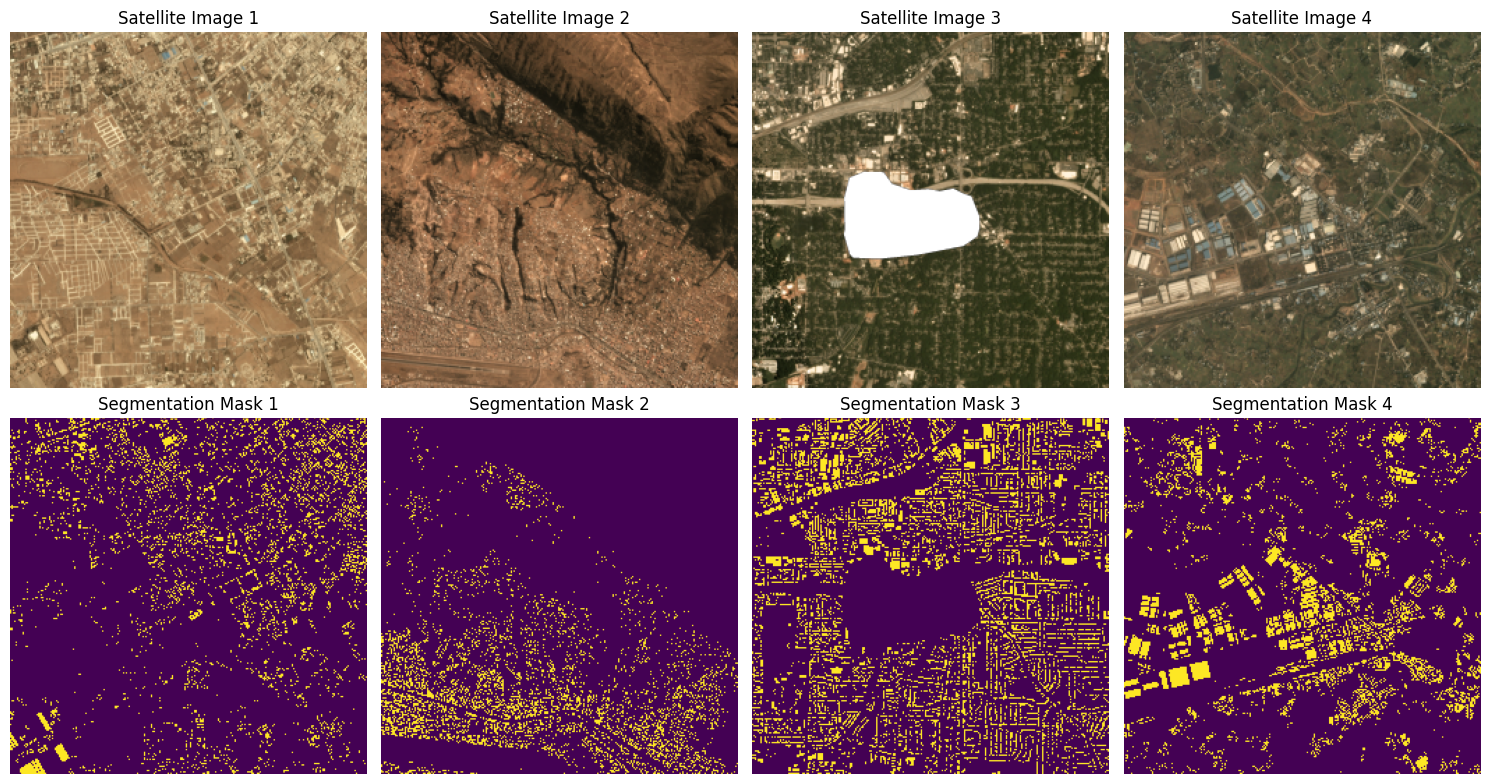


=== Additional Statistics ===
Number of training samples: 996
Image dimensions: (256, 256, 4)
Unique values in masks: [0. 1.]


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
X_train = np.load('../data/spacenet/X_train.npy')
y_train = np.load('../data/spacenet/y_train.npy')

# First, let's check what the data looks like
print("=== DATA CHECK ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_train dtype: {X_train.dtype}")
print(f"X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"y_train shape: {y_train.shape}")
print(f"y_train dtype: {y_train.dtype}")
print(f"y_train range: [{y_train.min():.3f}, {y_train.max():.3f}]")

# Display a single image first to test
print("\n=== Testing single image ===")
plt.figure(figsize=(6, 6))
plt.imshow(X_train[0])
plt.title("First Satellite Image - ACTUAL DATA")
plt.axis('off')
plt.show()

# Now display the full grid of images and masks
print("\n=== Displaying all images and masks ===")
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    # Display ACTUAL satellite image
    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title(f'Satellite Image {i+1}')
    axes[0, i].axis('off')
    
    # Display ACTUAL mask
    axes[1, i].imshow(y_train[i], cmap='viridis')
    axes[1, i].set_title(f'Segmentation Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Also show some statistics
print("\n=== Additional Statistics ===")
print(f"Number of training samples: {len(X_train)}")
print(f"Image dimensions: {X_train.shape[1:]}")

# Check if masks are binary or multi-class
unique_mask_values = np.unique(y_train)
print(f"Unique values in masks: {unique_mask_values}")

In [1]:
# Just to confirm everything matches your work
import numpy as np

X_train = np.load('../data/spacenet/X_train.npy')
print(f"Your X_train shape: {X_train.shape}")
print(f"Your X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")

# This should match what you already have!

Your X_train shape: (996, 256, 256, 4)
Your X_train range: [0.000, 1.000]
